In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [3]:
# Load preprocessed dataset
df = pd.read_csv(r"E:\GTech\Courses\ML\ML_Project\My_files\Midterm_checkpoint\datasets\FastF1\combining_quali_Fp2_data\qualifying_with_fp2_features_standardized_teams.csv")

# Drop inaccurate laps
df = df[df["IsAccurate"] == True].copy()

In [4]:
# Target
y = df["LapTime_seconds"]

In [5]:
# Features

categorical_cols = ["Driver", "Team", "Tyre", "CircuitType","FreshTyre", "GrandPrix"]   #adding fresh tyre feature 
numeric_cols = [
    "Year", "Round", "AirTemp", "Humidity", "Pressure", "Rainfall",
    "WindSpeed", "WindDirection", "TyreLife", "FP2_LapTime", "FP2_GapToBest"
]

#numeric_cols = [
#    "Year", "Round", "AirTemp", "Humidity", "Pressure", "Rainfall",
#    "WindSpeed", "WindDirection", "TyreLife", "Sector1Time", "Sector2Time", "Sector3Time", "FP2_LapTime", "FP2_GapToBest"
#]

In [6]:
X = df[categorical_cols + numeric_cols]

In [7]:
# Preprocessing
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer([
    ("cat", cat_pipeline, categorical_cols),
    ("num", num_pipeline, numeric_cols)
])


In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
# Define models and parameter grids
model_configs = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {}  
    },
    "Ridge Regression": {
        "model": Ridge(),
        "params": {"regressor__alpha": [0.01, 0.1, 1.0, 10.0]}
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "regressor__n_estimators": [50, 100],
            "regressor__max_depth": [None, 10, 20]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {
            "regressor__n_estimators": [50, 100],
            "regressor__learning_rate": [0.05, 0.1],
            "regressor__max_depth": [3, 5]
        }
    }
}

In [10]:
# Training loop with GridSearchCV
results = {}

for name, cfg in model_configs.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", cfg["model"])
    ])

    grid = GridSearchCV(pipe, cfg["params"], cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "Best Params": grid.best_params_
    }

In [11]:
# Results
results_df = pd.DataFrame(results).T.sort_values("RMSE")
print("\nModel Evaluation Metrics (Grid Search):\n")
print(results_df)


Model Evaluation Metrics (Grid Search):

                        MAE      RMSE        R2  \
Gradient Boosting  0.904313  2.397665  0.957351   
Random Forest      0.904175  2.482669  0.954273   
Ridge Regression   1.305577  2.678487  0.946776   
Linear Regression  1.305888  2.678577  0.946772   

                                                         Best Params  
Gradient Boosting  {'regressor__learning_rate': 0.1, 'regressor__...  
Random Forest      {'regressor__max_depth': None, 'regressor__n_e...  
Ridge Regression                          {'regressor__alpha': 0.01}  
Linear Regression                                                 {}  


In [12]:
results_df

,MAE,RMSE,R2,Best Params
Gradient Boosting,0.904313,2.397665,0.957351,"{'regressor__learning_rate': 0.1, 'regressor__..."
Random Forest,0.904175,2.482669,0.954273,"{'regressor__max_depth': None, 'regressor__n_e..."
Ridge Regression,1.305577,2.678487,0.946776,{'regressor__alpha': 0.01}
Linear Regression,1.305888,2.678577,0.946772,{}


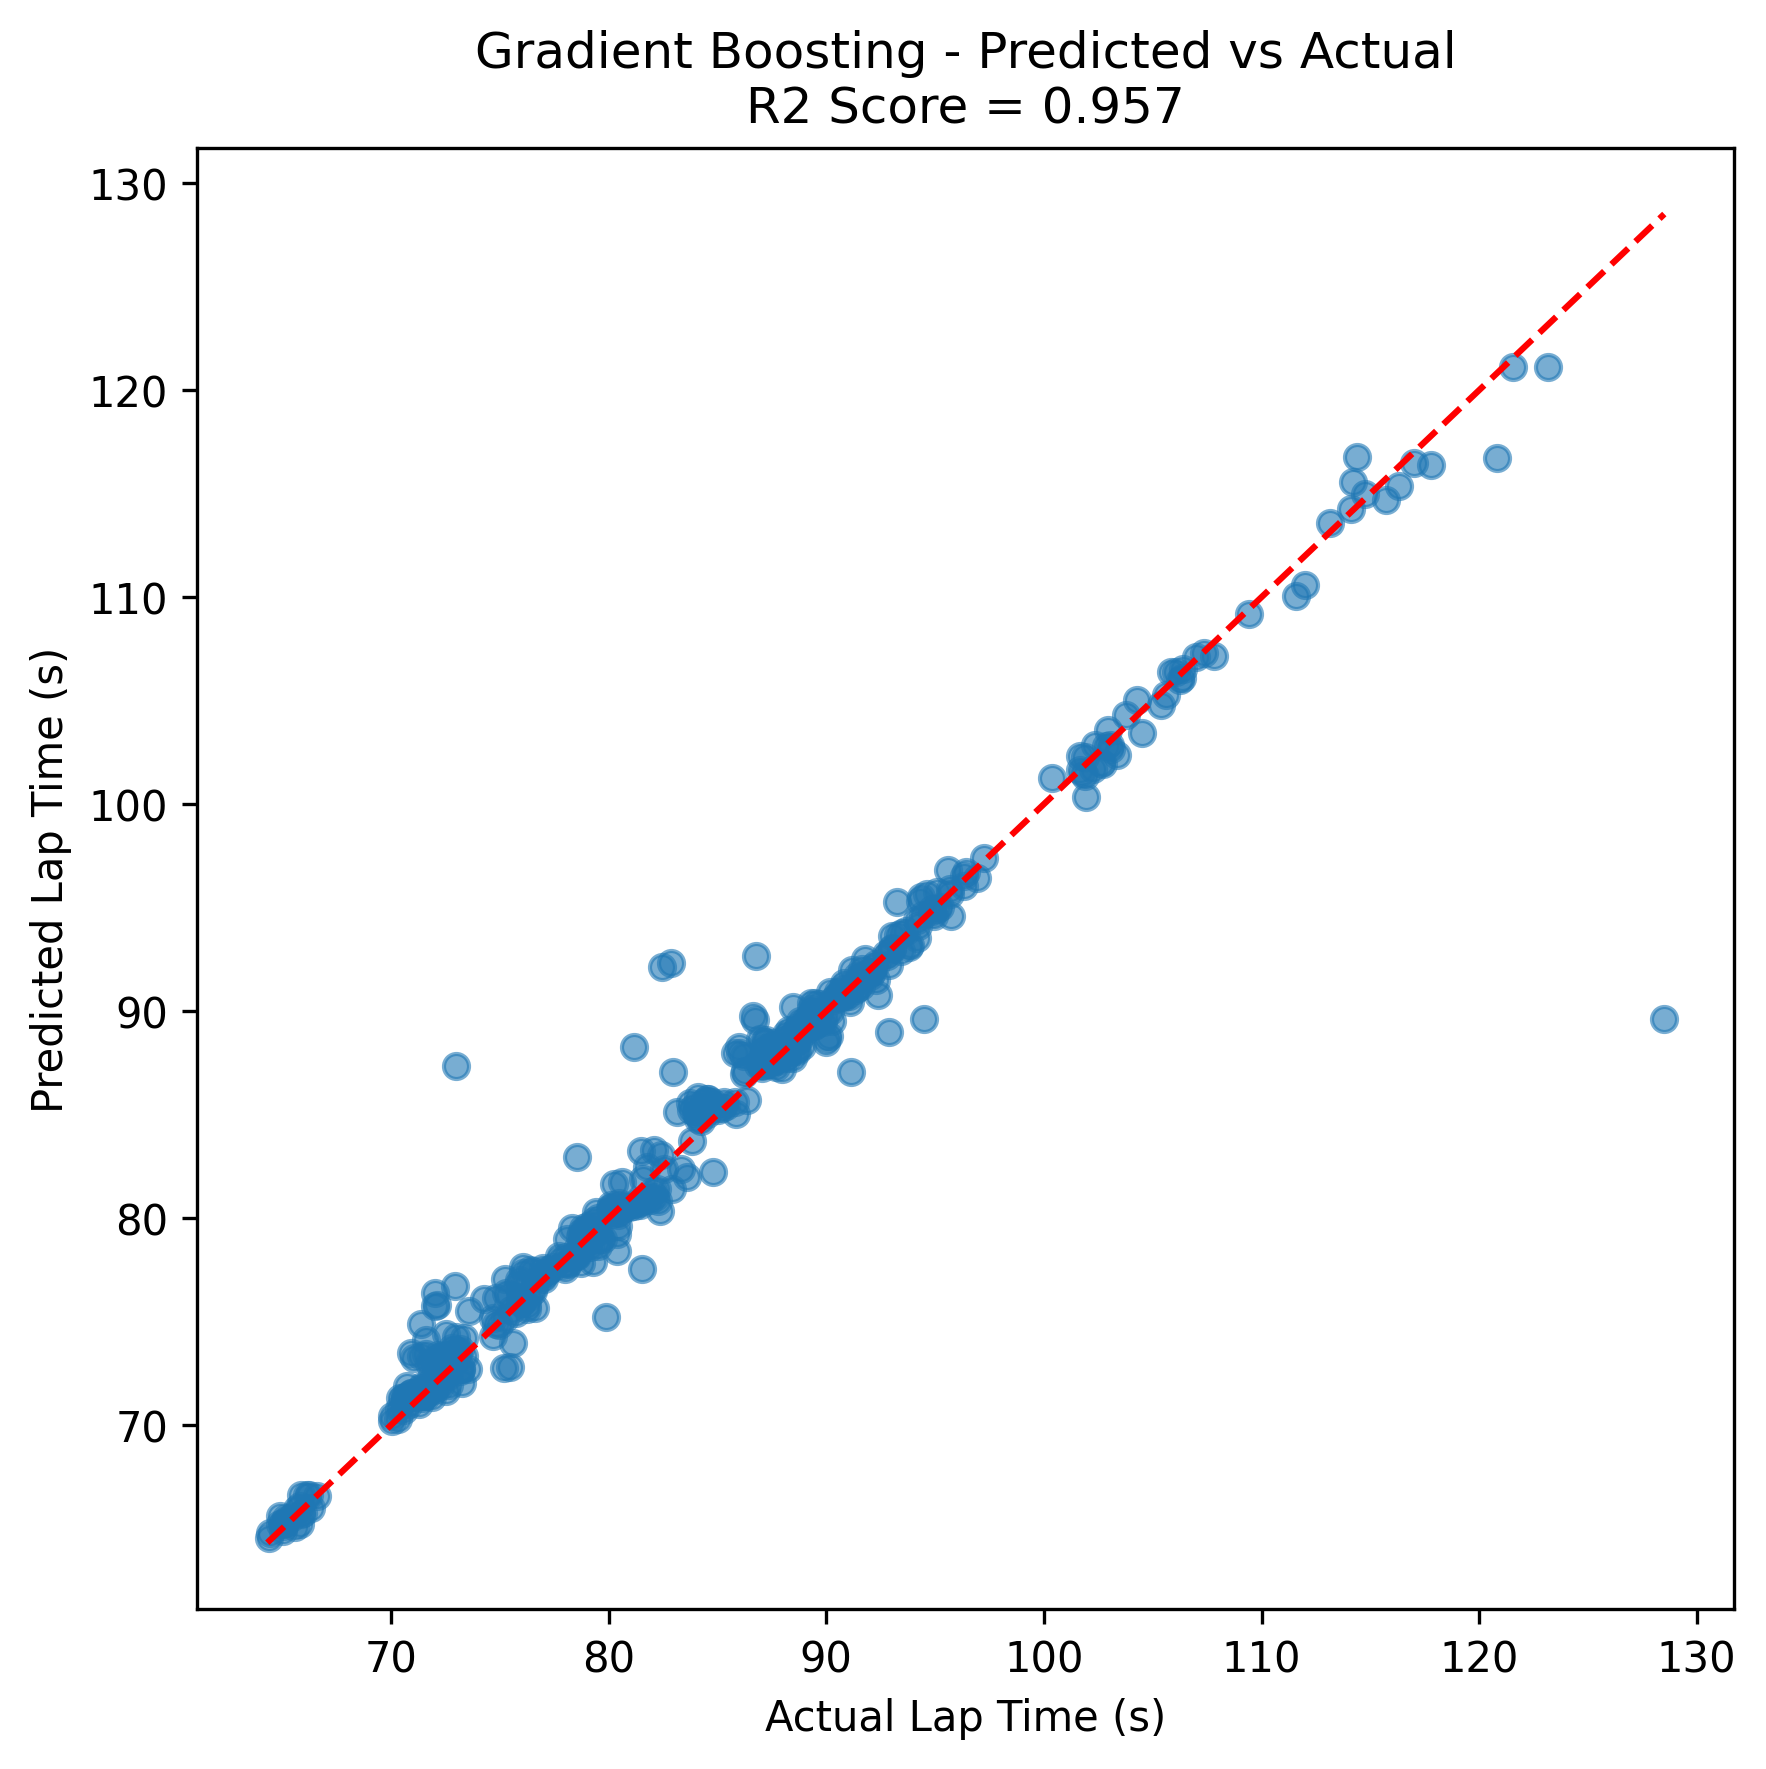

In [13]:
# Plot predicted vs actual for best model
best_model_name = results_df.index[0]
best_model_pipe = model_configs[best_model_name]["model"]
best_grid = GridSearchCV(
    Pipeline([("preprocessor", preprocessor), ("regressor", best_model_pipe)]),
    model_configs[best_model_name]["params"],
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)
best_grid.fit(X_train, y_train)
best_estimator = best_grid.best_estimator_
y_pred = best_estimator.predict(X_test)
r2_final = r2_score(y_test, y_pred)

plt.figure(figsize=(6, 6),dpi=300)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Lap Time (s)")
plt.ylabel("Predicted Lap Time (s)")
plt.title(f"{best_model_name} - Predicted vs Actual\nR2 Score = {r2_final:.3f}")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.tight_layout()
plt.show()

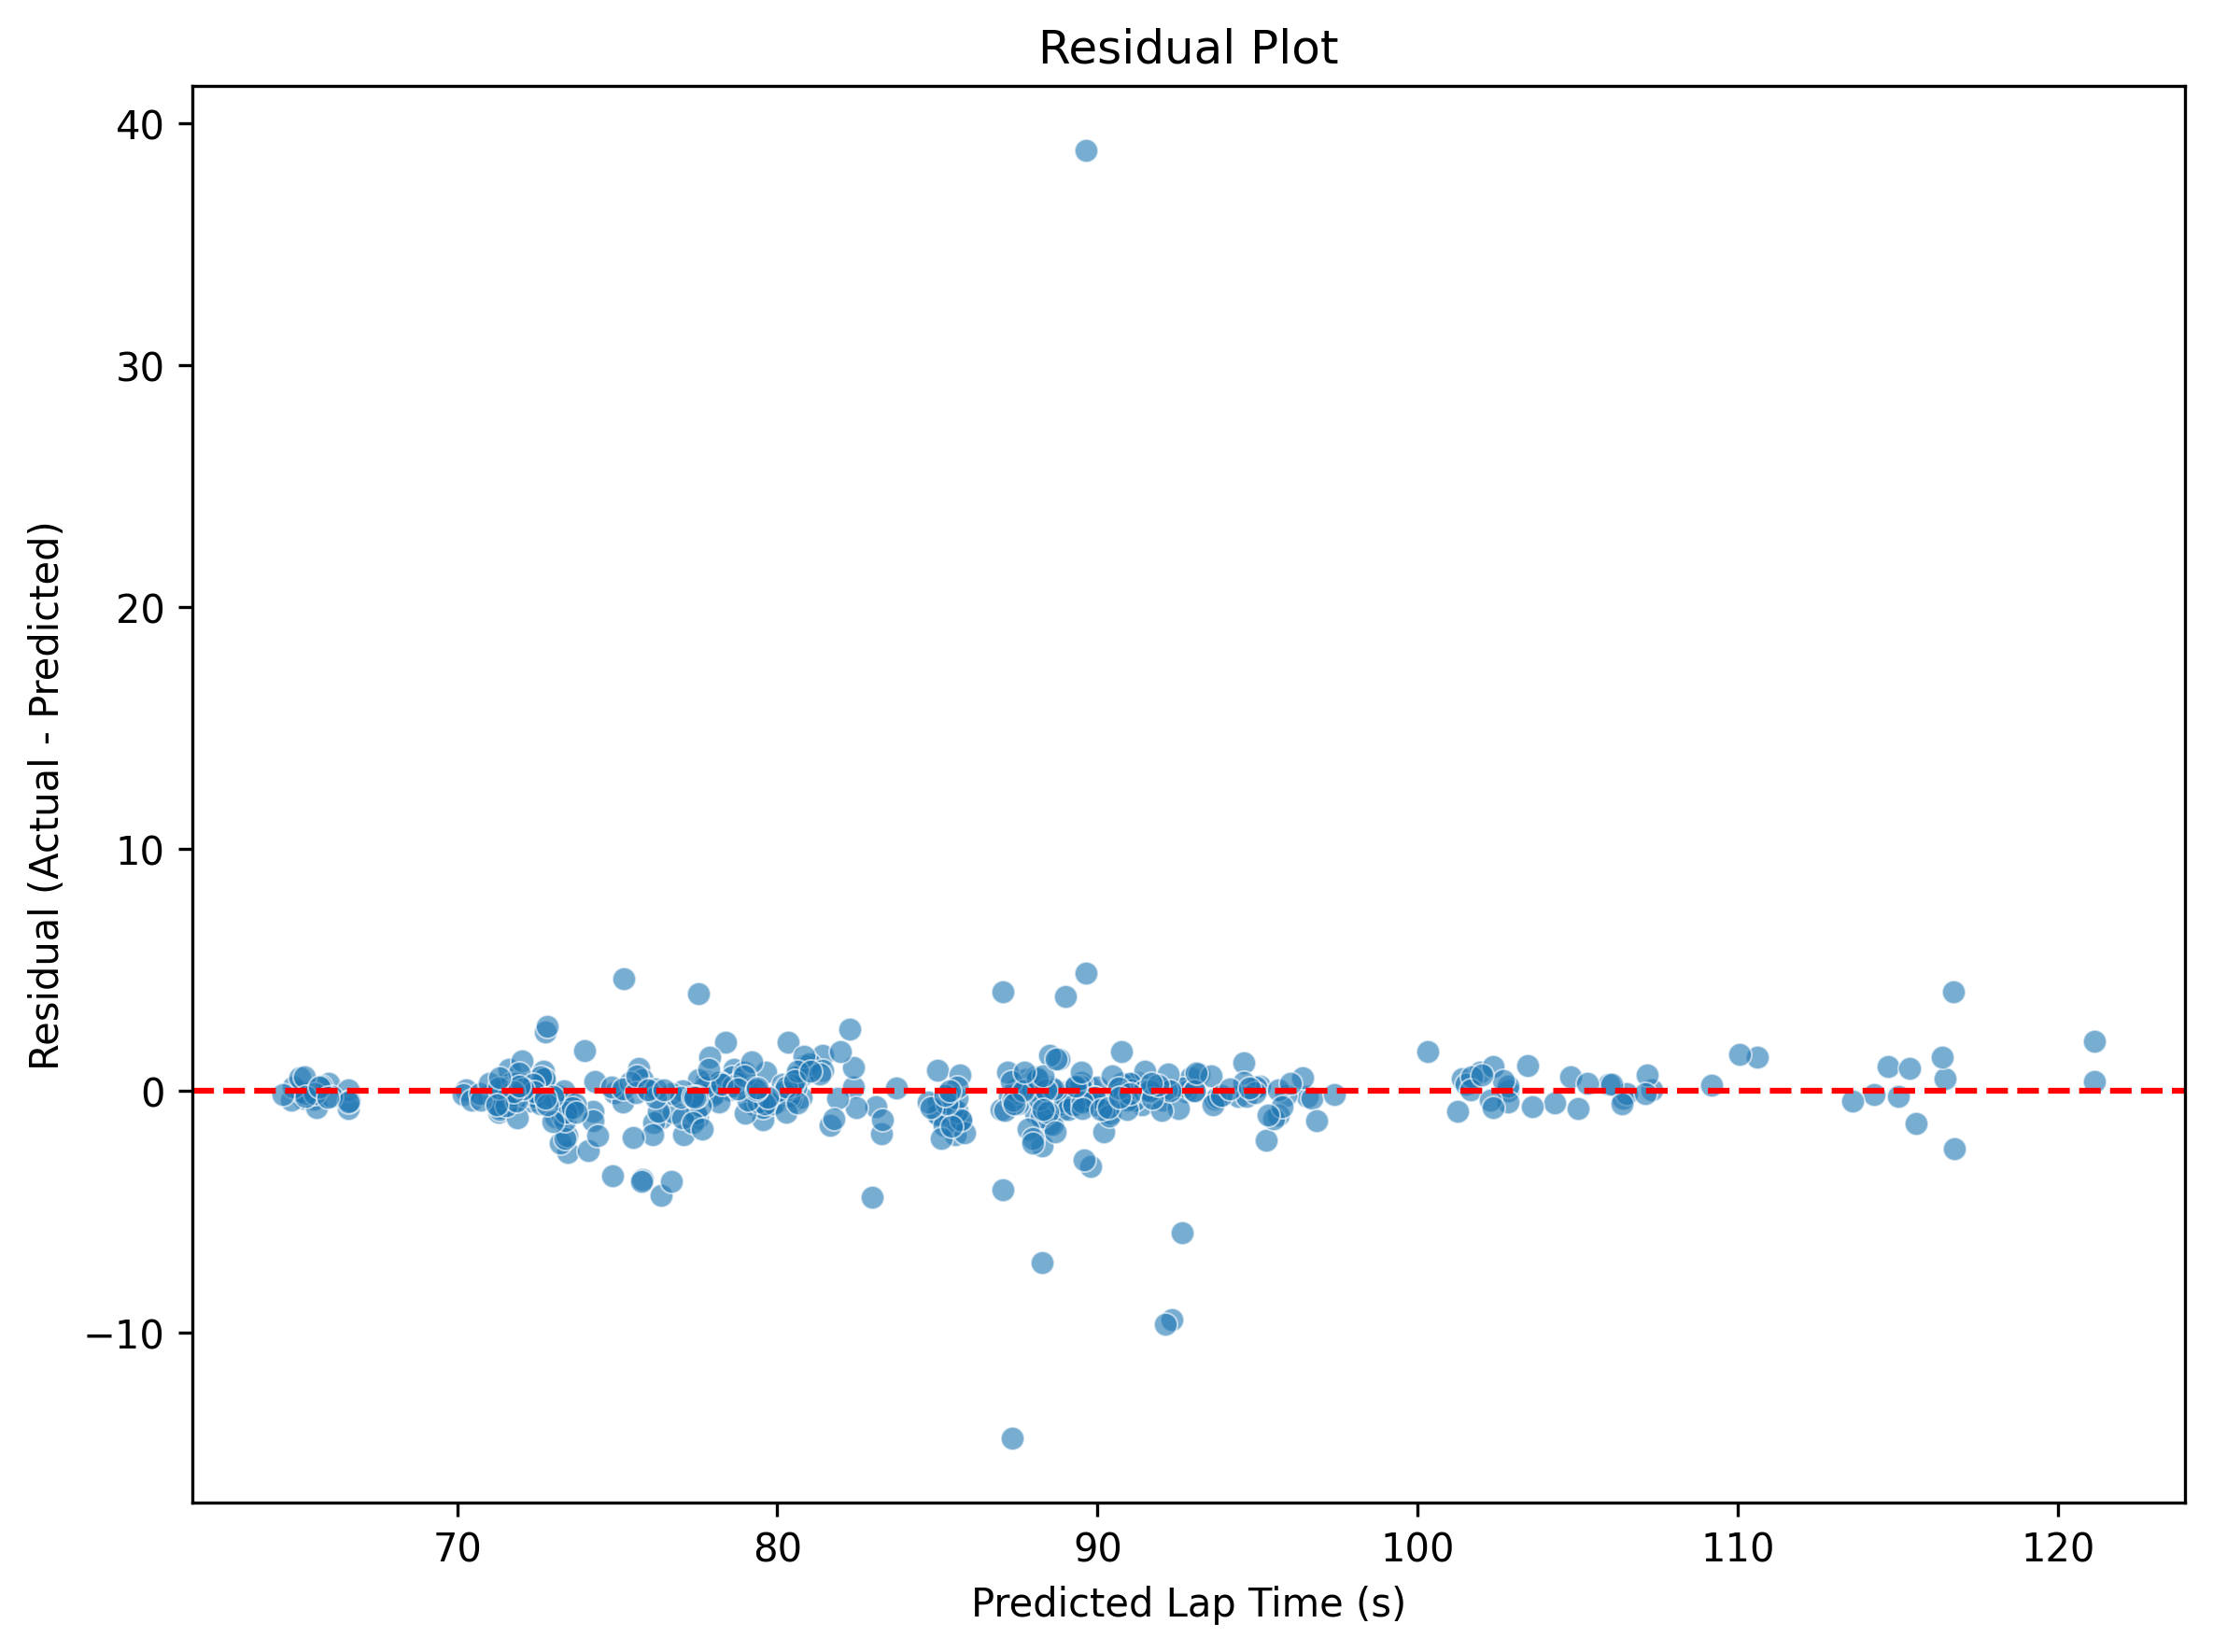

In [14]:
#Residual Plot
y_test_pred = best_estimator.predict(X_test)
residuals = y_test - y_test_pred

plt.figure(figsize=(8, 6), dpi=300)
sns.scatterplot(x=y_test_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Predicted Lap Time (s)")
plt.ylabel("Residual (Actual - Predicted)")
plt.tight_layout()
plt.show()


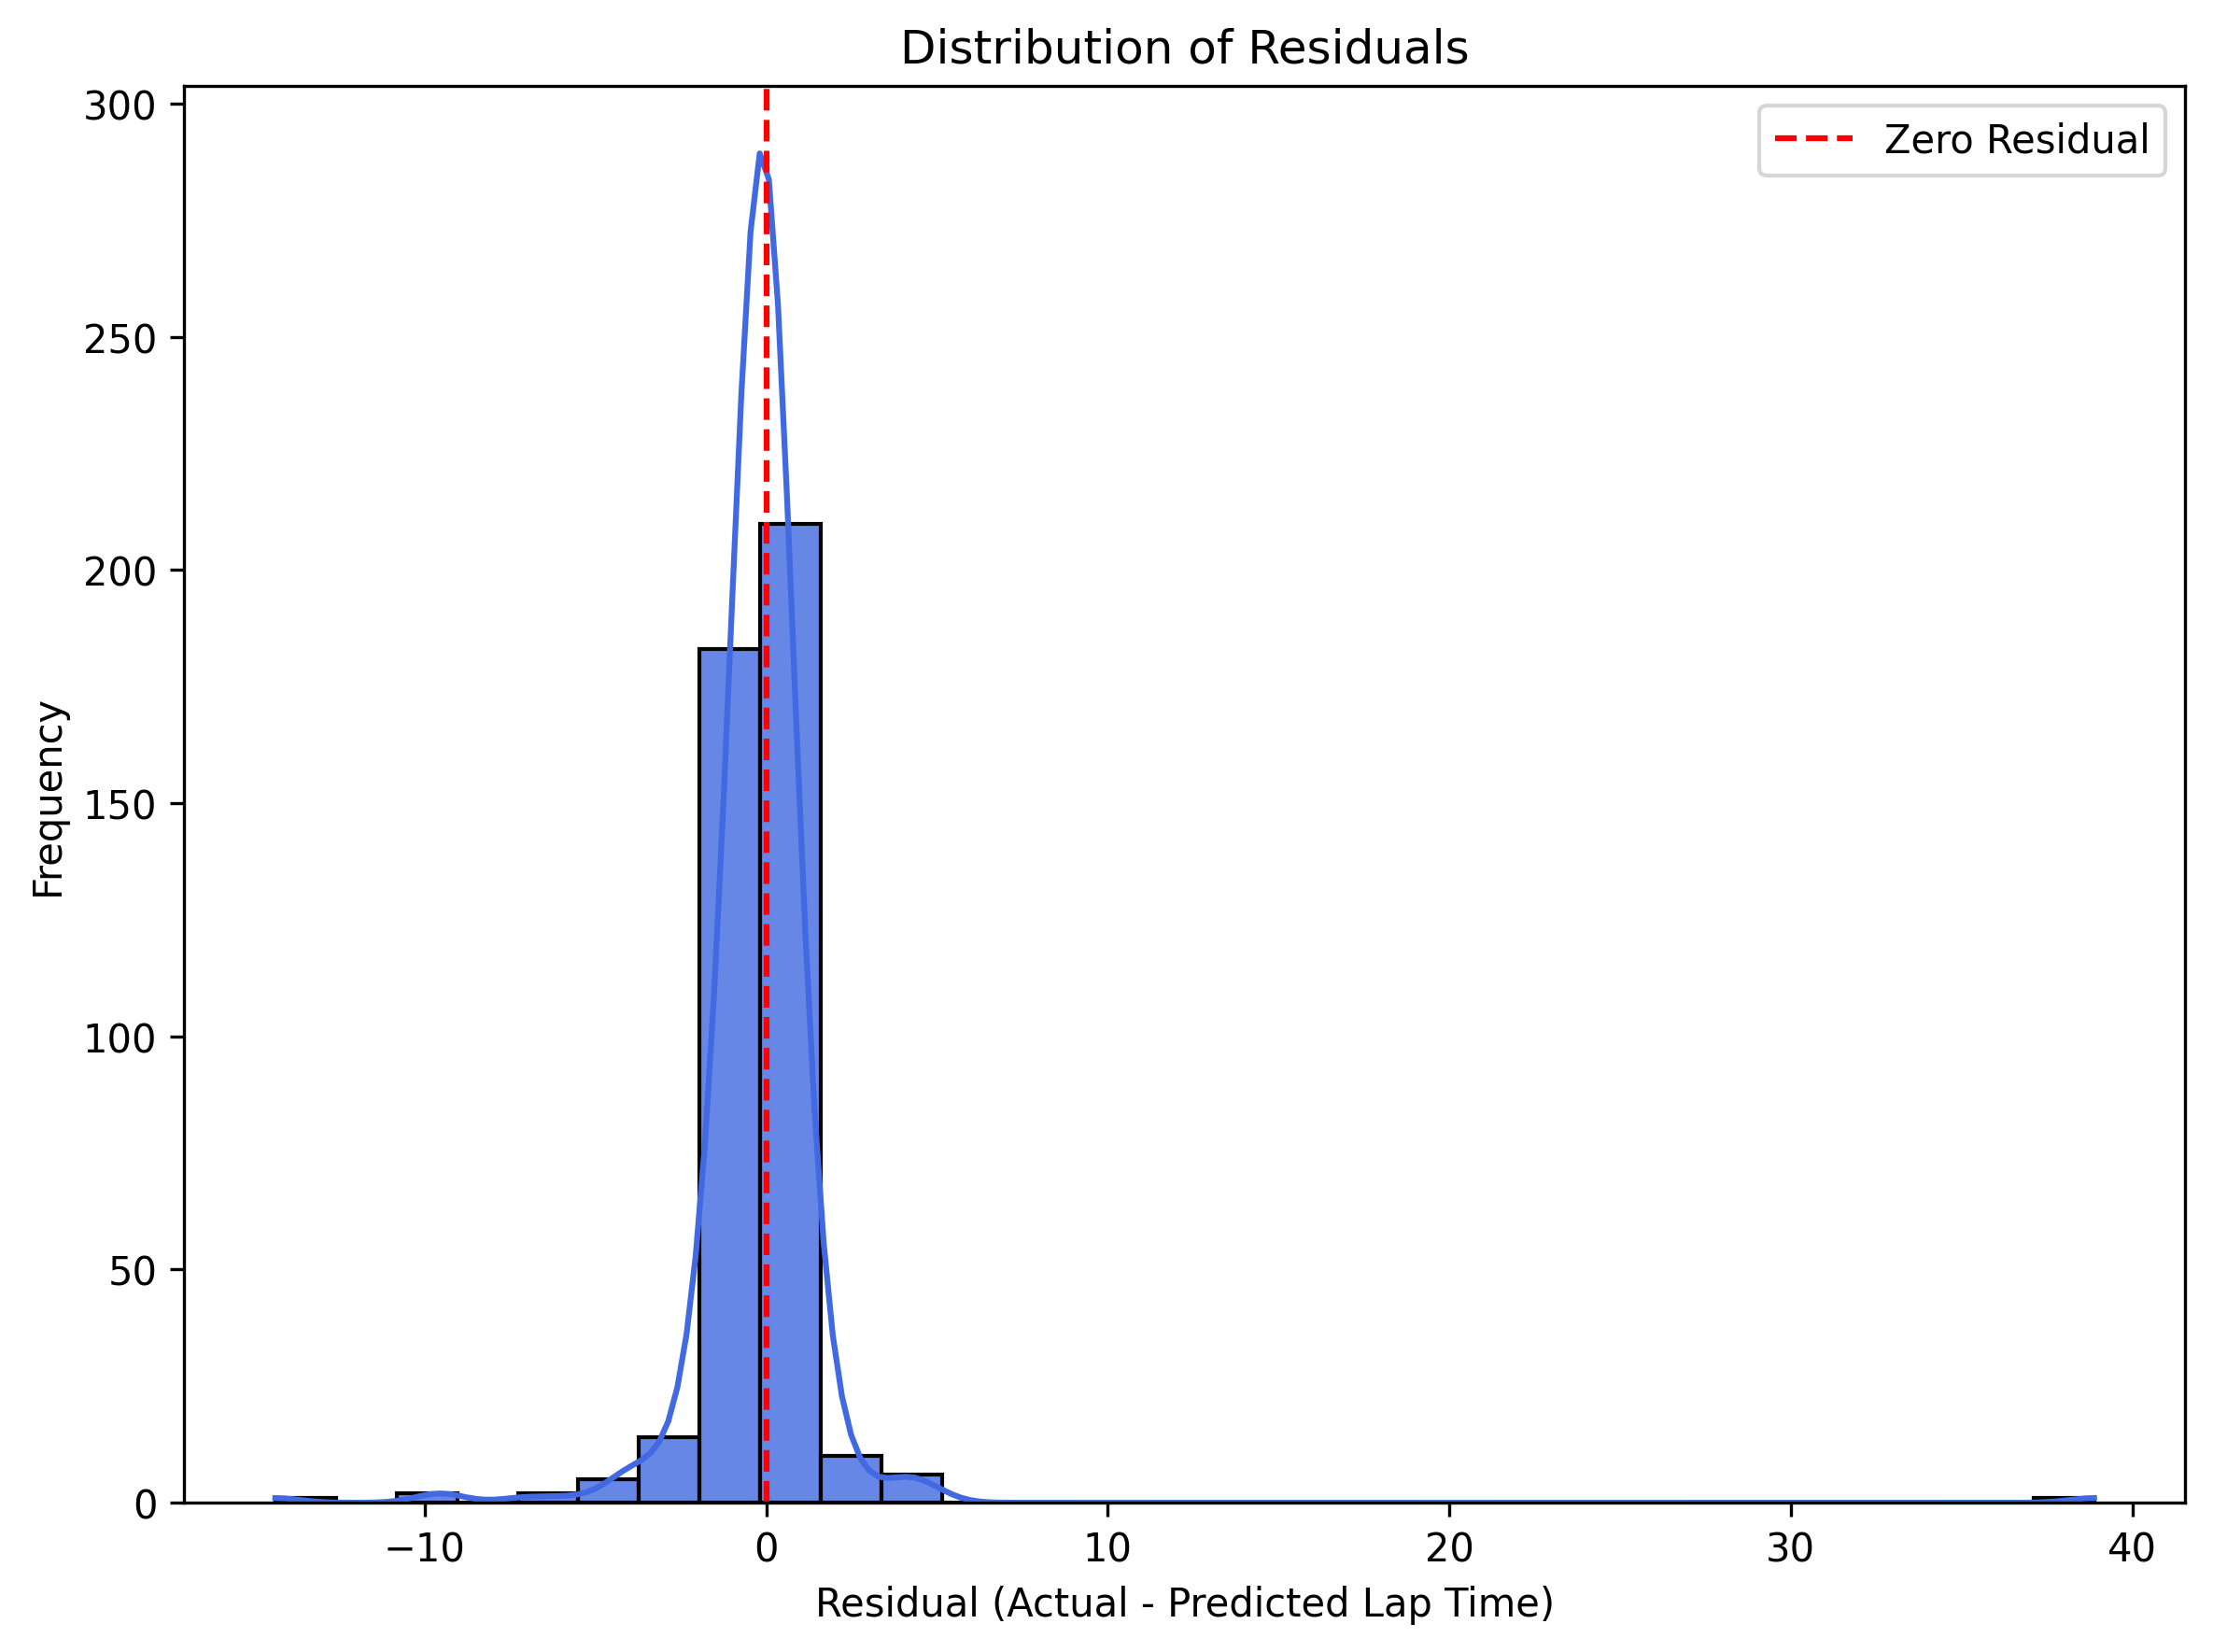

In [15]:
plt.figure(figsize=(8, 6), dpi=300)
sns.histplot(residuals, bins=30, kde=True, color='royalblue', alpha=0.8)
plt.axvline(0, color='red', linestyle='--', label="Zero Residual")
plt.title("Distribution of Residuals")
plt.xlabel("Residual (Actual - Predicted Lap Time)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
y_pred = best_estimator.predict(X_test)
X_test_with_meta = X_test.copy()
X_test_with_meta["ActualLapTime"] = y_test
X_test_with_meta["PredictedLapTime"] = y_pred

id_cols = ["Driver", "Team", "GrandPrix", "Year", "Round"]
merged = pd.merge(X_test_with_meta.reset_index(), df[id_cols], left_on="index", right_index=True)

In [17]:
race_df = merged[(merged["Year_x"] == 2023) & (merged["GrandPrix_x"] == "Miami Grand Prix")].copy()
race_df.sort_values("ActualLapTime", inplace=True)

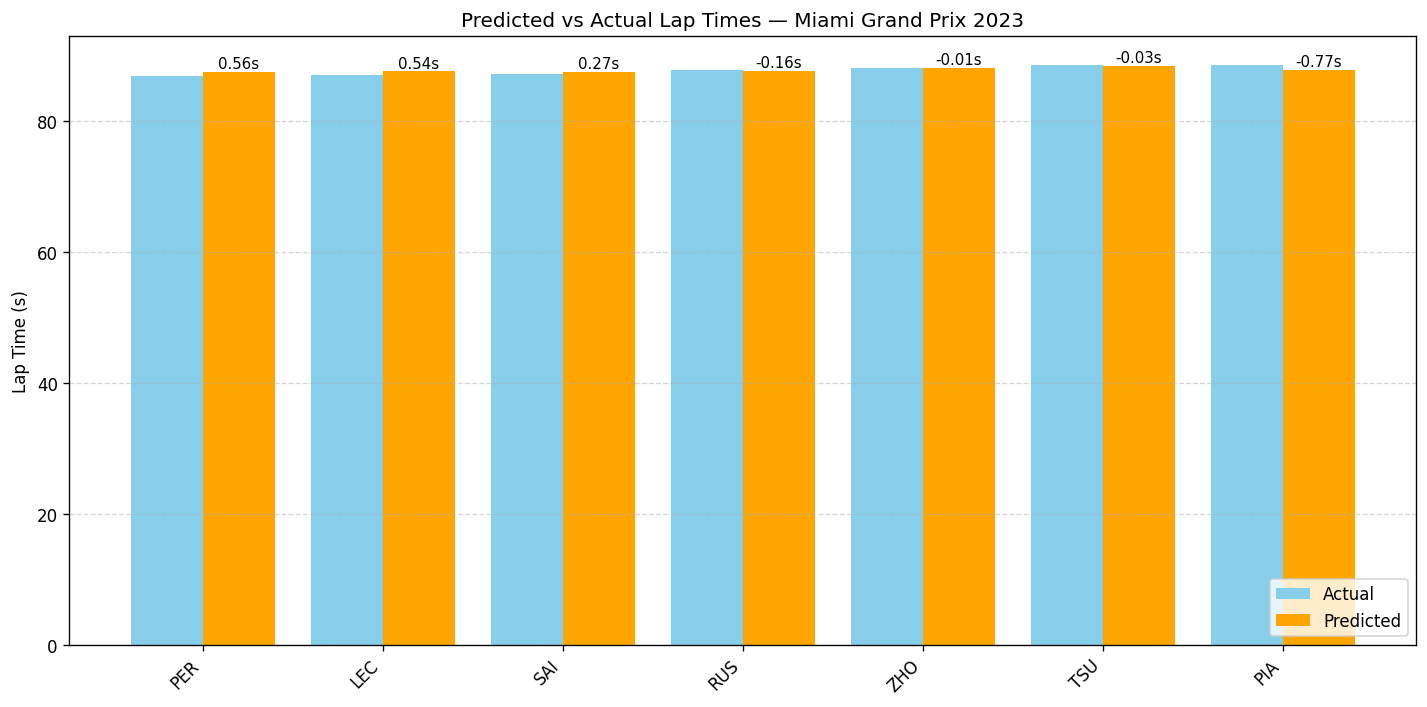

In [18]:
plt.figure(figsize=(12, 6), dpi=120)

bar_width = 0.4
indices = range(len(race_df))

# Residuals
residuals = race_df["PredictedLapTime"] - race_df["ActualLapTime"]

# Plot actual times
plt.bar(indices, race_df["ActualLapTime"], width=bar_width, label="Actual", color="skyblue")

# Plot predicted times next to actuals
plt.bar([i + bar_width for i in indices], race_df["PredictedLapTime"], width=bar_width, label="Predicted", color="orange")

# Driver labels
driver_labels = race_df["Driver_x"].values
plt.xticks([i + bar_width / 2 for i in indices], driver_labels, rotation=45, ha="right")

# Add error labels on predicted bars
for i, (x, res) in enumerate(zip(indices, residuals)):
    plt.text(x + bar_width, race_df["PredictedLapTime"].iloc[i] + 0.1,
             f"{res:.2f}s", ha='center', va='bottom', fontsize=9, color="black")

plt.ylabel("Lap Time (s)")
plt.title(f"Predicted vs Actual Lap Times — {race_df.iloc[0]['GrandPrix_x']} {race_df.iloc[0]['Year_x']}")
plt.legend(loc='lower right')
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


In [19]:
race_df = merged[(merged["Year_x"] == 2025) & (merged["GrandPrix_x"] == "Australian Grand Prix")].copy()
race_df.sort_values("ActualLapTime", inplace=True)

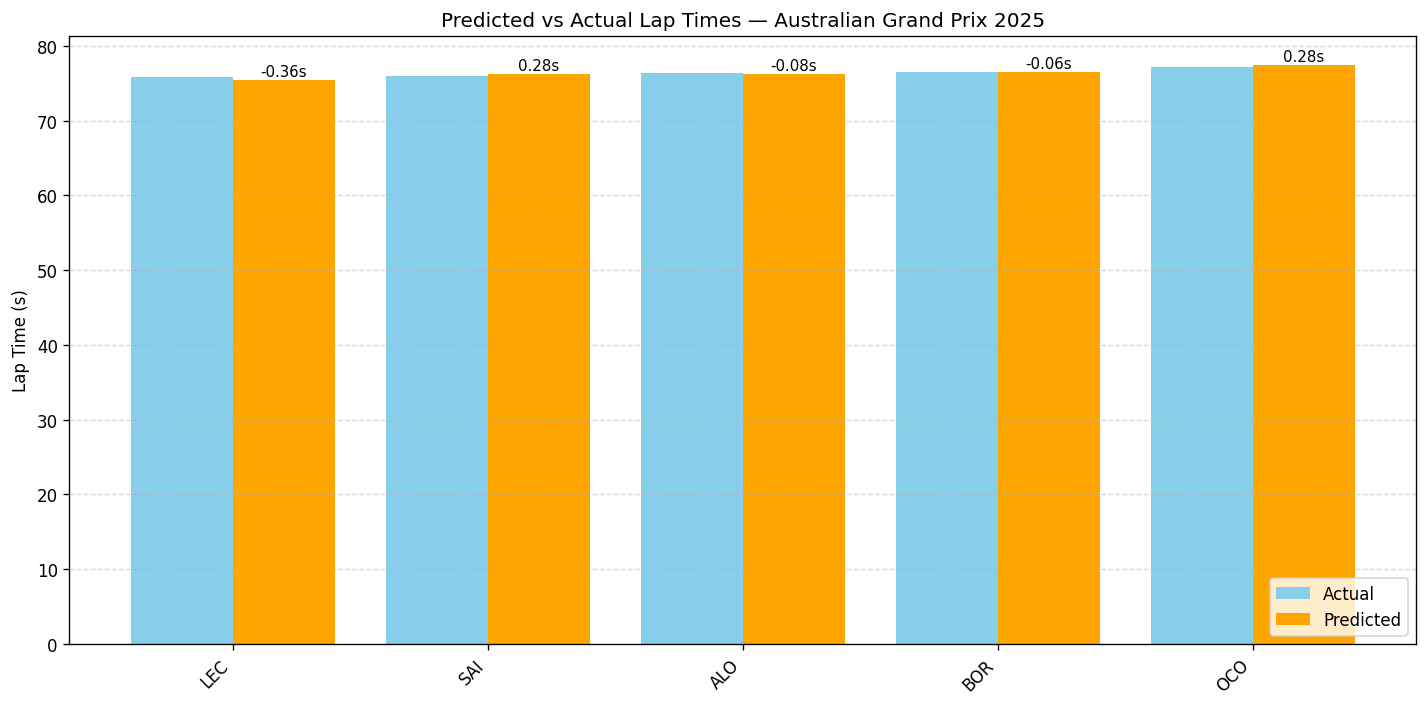

In [20]:
plt.figure(figsize=(12, 6), dpi=120)

bar_width = 0.4
indices = range(len(race_df))

# Residuals
residuals = race_df["PredictedLapTime"] - race_df["ActualLapTime"]

# Plot actual times
plt.bar(indices, race_df["ActualLapTime"], width=bar_width, label="Actual", color="skyblue")

# Plot predicted times next to actuals
plt.bar([i + bar_width for i in indices], race_df["PredictedLapTime"], width=bar_width, label="Predicted", color="orange")

# Driver labels
driver_labels = race_df["Driver_x"].values
plt.xticks([i + bar_width / 2 for i in indices], driver_labels, rotation=45, ha="right")

# Add error labels on predicted bars
for i, (x, res) in enumerate(zip(indices, residuals)):
    plt.text(x + bar_width, race_df["PredictedLapTime"].iloc[i] + 0.1,
             f"{res:.2f}s", ha='center', va='bottom', fontsize=9, color="black")

plt.ylabel("Lap Time (s)")
plt.title(f"Predicted vs Actual Lap Times — {race_df.iloc[0]['GrandPrix_x']} {race_df.iloc[0]['Year_x']}")
plt.legend(loc='lower right')
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

In [21]:
race_df = merged[(merged["Year_x"] == 2025) & (merged["GrandPrix_x"] == "Canadian Grand Prix")].copy()
race_df.sort_values("ActualLapTime", inplace=True)

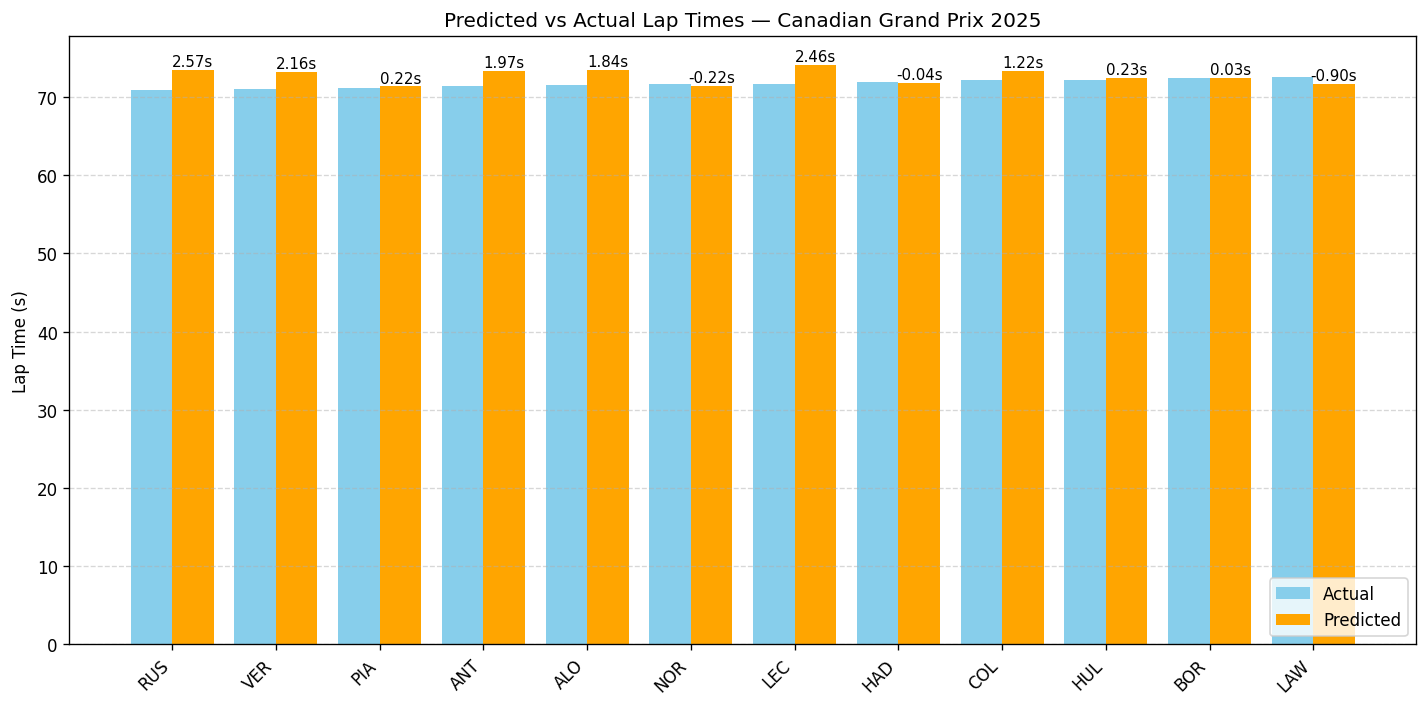

In [22]:
plt.figure(figsize=(12, 6), dpi=120)

bar_width = 0.4
indices = range(len(race_df))

# Residuals
residuals = race_df["PredictedLapTime"] - race_df["ActualLapTime"]

# Plot actual times
plt.bar(indices, race_df["ActualLapTime"], width=bar_width, label="Actual", color="skyblue")

# Plot predicted times next to actuals
plt.bar([i + bar_width for i in indices], race_df["PredictedLapTime"], width=bar_width, label="Predicted", color="orange")

# Driver labels
driver_labels = race_df["Driver_x"].values
plt.xticks([i + bar_width / 2 for i in indices], driver_labels, rotation=45, ha="right")

# Add error labels on predicted bars
for i, (x, res) in enumerate(zip(indices, residuals)):
    plt.text(x + bar_width, race_df["PredictedLapTime"].iloc[i] + 0.1,
             f"{res:.2f}s", ha='center', va='bottom', fontsize=9, color="black")

plt.ylabel("Lap Time (s)")
plt.title(f"Predicted vs Actual Lap Times — {race_df.iloc[0]['GrandPrix_x']} {race_df.iloc[0]['Year_x']}")
plt.legend(loc='lower right')
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()